In [2]:
# import required packages
from imodels import get_clean_dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from imodels.tree.rf_plus.rf_plus.rf_plus_models import RandomForestPlusRegressor, RandomForestPlusClassifier
from imodels.tree.rf_plus.feature_importance.rfplus_explainer import RFPlusMDI
from sklearn.linear_model import RidgeCV, LogisticRegression
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from joypy import joyplot

In [3]:
# get pre-cleaned compas dataset from imodels
X, y, feature_names = get_clean_dataset('diabetes_regr', data_source='imodels')
X = pd.DataFrame(X, columns=feature_names)

fetching diabetes from sklearn


In [4]:
# get correlation matrix of X's
corr = X.corr()
corr

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
age,1.000000,0.173737,0.185085,0.335428,0.260061,0.219243,-0.075181,0.203841,0.270774,0.301731
sex,0.173737,1.000000,0.088161,0.241010,0.035277,0.142637,-0.379090,0.332115,0.149916,0.208133
bmi,0.185085,0.088161,1.000000,0.395411,0.249777,0.261170,-0.366811,0.413807,0.446157,0.388680
bp,0.335428,0.241010,0.395411,1.000000,0.242464,0.185548,-0.178762,0.257650,0.393480,0.390430
s1,0.260061,0.035277,0.249777,0.242464,1.000000,0.896663,0.051519,0.542207,0.515503,0.325717
s2,0.219243,0.142637,0.261170,0.185548,0.896663,1.000000,-0.196455,0.659817,0.318357,0.290600
s3,-0.075181,-0.379090,-0.366811,-0.178762,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697
s4,0.203841,0.332115,0.413807,0.257650,0.542207,0.659817,-0.738493,1.000000,0.617859,0.417212
s5,0.270774,0.149916,0.446157,0.393480,0.515503,0.318357,-0.398577,0.617859,1.000000,0.464669
s6,0.301731,0.208133,0.388680,0.390430,0.325717,0.290600,-0.273697,0.417212,0.464669,1.000000


In [3]:
# set seed
np.random.seed(0)
# get pre-cleaned compas dataset from imodels
X, y, feature_names = get_clean_dataset(183, data_source='openml')
X = pd.DataFrame(X, columns=feature_names)
# convert y to float
y = y.astype(float)

In [4]:
# get proportion of X that has gender 0/1/2
gender = X["Sex"]
print("Proportion of data with Gender 0: ", sum(gender == 0)/len(gender))
print("Proportion of data with Gender 1: ", sum(gender == 1)/len(gender))
print("Proportion of data with Gender 2: ", sum(gender == 2)/len(gender))

Proportion of data with Gender 0:  0.31290399808474983
Proportion of data with Gender 1:  0.32128321762030165
Proportion of data with Gender 2:  0.3658127842949485


Plot demonstrating subgroup impact on outcome:


/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

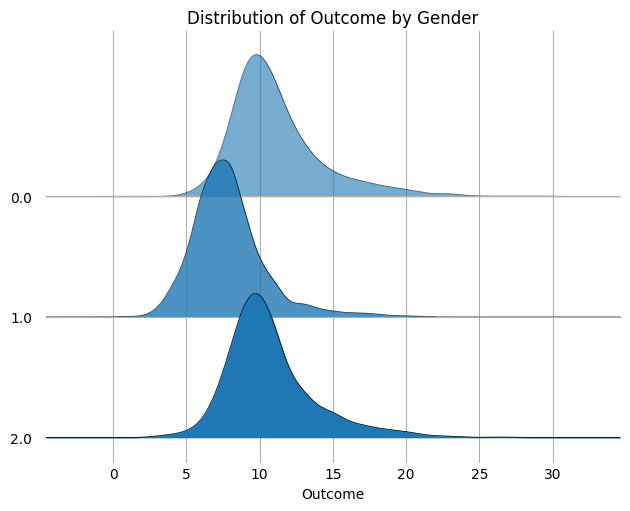

In [5]:
print("Plot demonstrating subgroup impact on outcome:")
# Create the joyplot
plt.figure(figsize=(10, 6))
joyplot(
    data=X.assign(y=y),
    by='Sex',
    column='y',
    fade=True,
    grid=True,
    linecolor='k',
    linewidth=0.5
)

plt.title('Distribution of Outcome by Gender')
plt.xlabel('Outcome')
plt.ylabel('Density')
plt.show()

In [6]:
# split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=2)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [7]:
# fit RF model
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

# fit RF+ model
rf_plus = RandomForestPlusRegressor(rf_model = rf, prediction_model = RidgeCV())
rf_plus.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


In [8]:
# get TreeSHAP importances and rankings
explainer = shap.TreeExplainer(rf)
shap_values = np.abs(explainer.shap_values(X_train, check_additivity=False))
shap_rankings = np.argsort(-shap_values, axis = 1)

In [9]:
# get LMDI+ importances and rankings
rfplus_explainer = RFPlusMDI(rf_plus)
lmdi_values = np.abs(rfplus_explainer.explain_linear_partial(np.asarray(X_train), y_train, l2norm=True, njobs = 1))
lmdi_rankings = rfplus_explainer.get_rankings(lmdi_values)

In [10]:
# sort based highest y to lowest y
sorted_indices = np.argsort(-y_train)
sorted_lmdi_values = lmdi_values[sorted_indices]
sorted_lmdi_rankings = lmdi_rankings[sorted_indices]
sorted_shap_values = shap_values[sorted_indices]
sorted_shap_rankings = shap_rankings[sorted_indices]

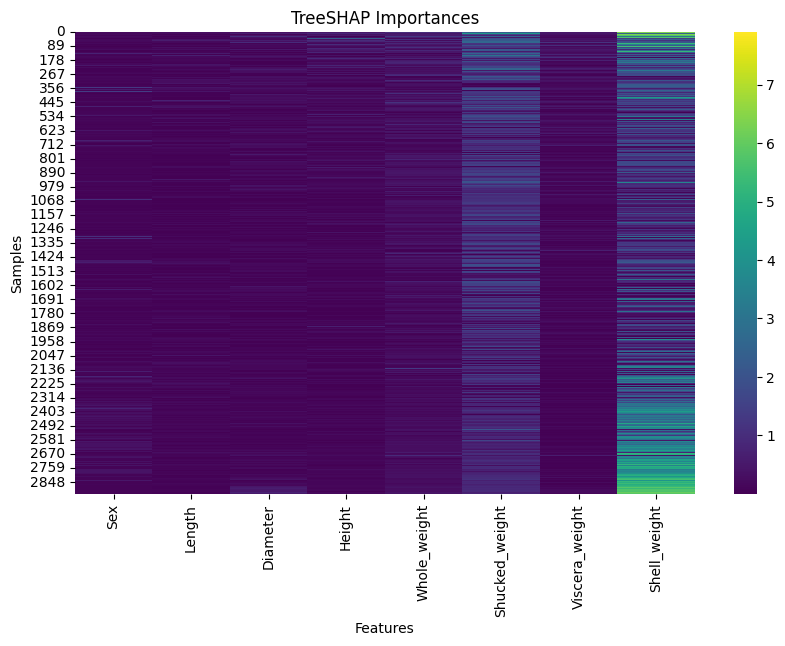

In [11]:
# plot heatmap of LMDI+ importances based on true y
plt.figure(figsize=(10, 6))
sns.heatmap(sorted_shap_values, cmap='viridis')
plt.title('TreeSHAP Importances')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.xticks(ticks = np.arange(X_train.shape[1]) + 0.5, labels = X_train.columns, rotation = 90)
plt.show()

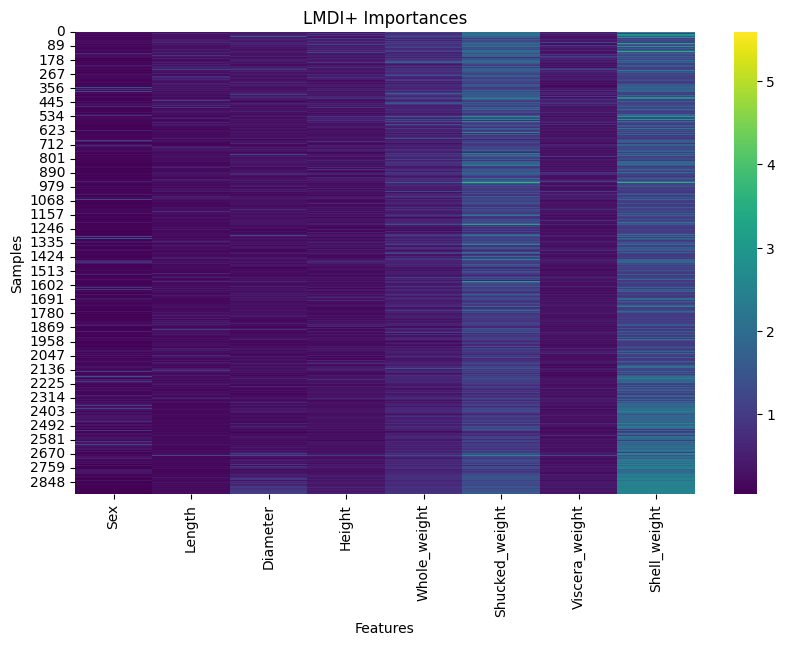

In [12]:
# plot heatmap of LMDI+ importances based on true y
plt.figure(figsize=(10, 6))
sns.heatmap(sorted_lmdi_values, cmap='viridis')
plt.title('LMDI+ Importances')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.xticks(ticks = np.arange(X_train.shape[1]) + 0.5, labels = X_train.columns, rotation = 90)
plt.show()

In [107]:
lmdi_sub_imp = pd.concat([X_train["Sex"].reset_index(drop=True), pd.DataFrame(lmdi_rankings)], axis=1)

In [108]:
shap_sub_imp = pd.concat([X_train["Sex"].reset_index(drop=True), pd.DataFrame(shap_rankings)], axis=1)

In [109]:
lmdi_mean_rankings = lmdi_sub_imp.groupby('Sex', observed=False).mean().reset_index()
# rank features for each row
lmdi_ranked_mean_rankings = lmdi_mean_rankings.drop(columns=["Sex"]).rank(axis=1)
lmdi_ranked_mean_rankings.columns = X.columns
print("Subgroup feature rankings for LMDI+:")
lmdi_ranked_mean_rankings

Subgroup feature rankings for LMDI+:


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0
1,8.0,7.0,6.0,4.0,3.0,5.0,2.0,1.0
2,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0


In [110]:
shap_mean_rankings = shap_sub_imp.groupby('Sex', observed=False).mean().reset_index()
# rank features for each row
shap_ranked_mean_rankings = shap_mean_rankings.drop(columns=["Sex"]).rank(axis=1)
shap_ranked_mean_rankings.columns = X.columns
print("Subgroup feature rankings for TreeSHAP:")
shap_ranked_mean_rankings

Subgroup feature rankings for TreeSHAP:


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,8.0,7.0,6.0,5.0,4.0,3.0,1.0,2.0
1,8.0,7.0,3.0,6.0,4.0,2.0,1.0,5.0
2,8.0,7.0,6.0,5.0,4.0,2.0,1.0,3.0


In [111]:
def mask_feature(row, i, ranked_mean_rankings):
    return ranked_mean_rankings.iloc[int(row['Sex'])].sort_values().index[i]


In [112]:
X_train_copy = X_train.copy()
mse_list = []
mse_list.append(np.mean((rf.predict(X_train_copy) - y_train)**2))
for i in range(X_train.shape[1]):
    # if the gender is 0, mask the feature with importance == i in the 0th row of shap_ranked_mean_rankings
    for j in range(X_train.shape[0]):
        feature_to_mask = mask_feature(X_train.iloc[j,], i, shap_ranked_mean_rankings)
        X_train_copy.loc[j, feature_to_mask] = X_train[feature_to_mask].mean()
    mse = np.mean((rf.predict(X_train_copy) - y_train)**2)
    mse_list.append(mse)
mse_arr_shap = np.array(mse_list)
# get difference between elements of mse_list
diff_shap = np.abs(np.diff(mse_arr_shap))
# get cumulative sum of differences
cumulative_diff_shap = np.cumsum(diff_shap)

In [113]:
X_train_copy = X_train.copy()
mse_list = []
mse_list.append(np.mean((rf_plus.predict(X_train_copy) - y_train)**2))
for i in range(X_train.shape[1]):
    # if the gender is 0, mask the feature with importance == i in the 0th row of shap_ranked_mean_rankings
    for j in range(X_train.shape[0]):
        feature_to_mask = mask_feature(X_train.iloc[j,], i, lmdi_ranked_mean_rankings)
        X_train_copy.loc[j, feature_to_mask] = X_train[feature_to_mask].mean()
    mse = np.mean((rf_plus.predict(X_train_copy) - y_train)**2)
    mse_list.append(mse)
mse_arr_lmdi = np.array(mse_list)
# get difference between elements of mse_list
diff_lmdi = np.abs(np.diff(mse_arr_lmdi))
# get cumulative sum of differences
cumulative_diff_lmdi = np.cumsum(diff_lmdi)

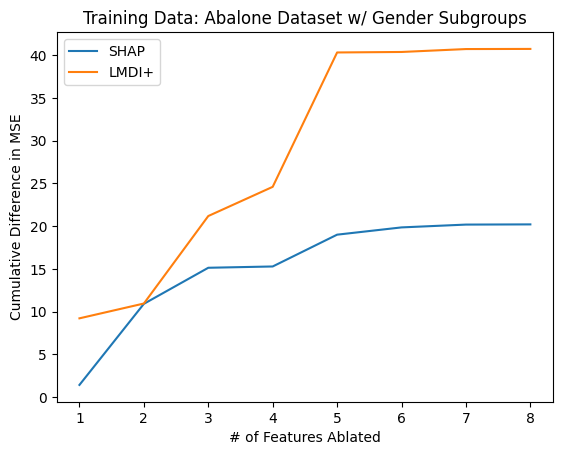

In [114]:
# plot cumulative differences in mse vs number of features ablated
plt.plot(cumulative_diff_shap, label = 'SHAP')
plt.plot(cumulative_diff_lmdi, label = 'LMDI+')
plt.xlabel('# of Features Ablated')
plt.ylabel('Cumulative Difference in MSE')
# x ticks should be labeled 1-X_train.shape[1]
plt.xticks(np.arange(0, X_train.shape[1], 1), np.arange(1, X_train.shape[1]+1, 1))
plt.title('Training Data: Abalone Dataset w/ Gender Subgroups')
plt.legend()
plt.show()


In [115]:
X_test_copy = X_test.copy()
mse_list = []
mse_list.append(np.mean((rf.predict(X_test_copy) - y_test)**2))
for i in range(X_test.shape[1]):
    # if the gender is 0, mask the feature with importance == i in the 0th row of shap_ranked_mean_rankings
    for j in range(X_test.shape[0]):
        feature_to_mask = mask_feature(X_test.iloc[j,], i, shap_ranked_mean_rankings)
        X_test_copy.loc[j, feature_to_mask] = X_test[feature_to_mask].mean()
    mse = np.mean((rf.predict(X_test_copy) - y_test)**2)
    mse_list.append(mse)
mse_arr_shap = np.array(mse_list)
# get difference between elements of mse_list
diff_shap = np.abs(np.diff(mse_arr_shap))
# get cumulative sum of differences
cumulative_diff_shap_test = np.cumsum(diff_shap)

In [116]:
X_test_copy = X_test.copy()
mse_list = []
mse_list.append(np.mean((rf_plus.predict(X_test_copy) - y_test)**2))
for i in range(X_test.shape[1]):
    # if the gender is 0, mask the feature with importance == i in the 0th row of shap_ranked_mean_rankings
    for j in range(X_test.shape[0]):
        feature_to_mask = mask_feature(X_test.iloc[j,], i, lmdi_ranked_mean_rankings)
        X_test_copy.loc[j, feature_to_mask] = X_test[feature_to_mask].mean()
    mse = np.mean((rf_plus.predict(X_test_copy) - y_test)**2)
    mse_list.append(mse)
mse_arr_lmdi = np.array(mse_list)
# get difference between elements of mse_list
diff_lmdi = np.abs(np.diff(mse_arr_lmdi))
# get cumulative sum of differences
cumulative_diff_lmdi_test = np.cumsum(diff_lmdi)

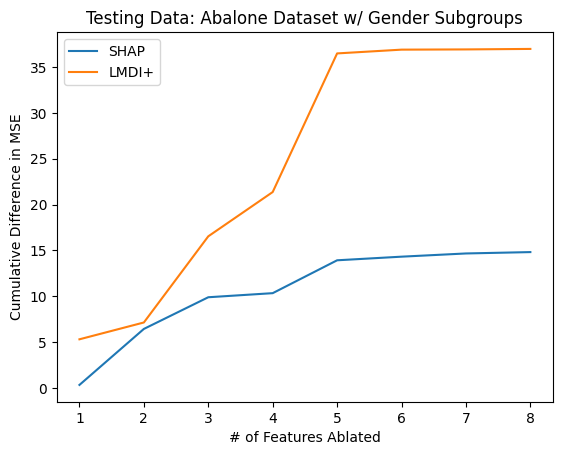

In [117]:
# plot cumulative differences in mse vs number of features ablated
plt.plot(cumulative_diff_shap_test, label = 'SHAP')
plt.plot(cumulative_diff_lmdi_test, label = 'LMDI+')
plt.xlabel('# of Features Ablated')
plt.ylabel('Cumulative Difference in MSE')
# x ticks should be labeled 1-X_train.shape[1]
plt.xticks(np.arange(0, X_train.shape[1], 1), np.arange(1, X_train.shape[1]+1, 1))
plt.title('Testing Data: Abalone Dataset w/ Gender Subgroups')
plt.legend()
plt.show()